<font size = "5"> **Day 3: [Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization](../MLSTEM2024.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/gduscher/MLSTEM2024//main/Day3/4-Low_Loss_EELS.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day3/4-Low_Loss_EELS.ipynb)


# Analysing Low-Loss Spectra with Drude Theory
Lecturer: Gerd Duscher

part of the workshop of 

<font size = "5"> **[Machine Learning in Scanning Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day3: Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

## Overview
We explore all the values we can extract from a low-loss EELS spectrum 

One the one hand low-loss EELS spectra are easy to acquire on the other hand, these spectra are under quantified.


## Load packages
### Check for Newest Versions


## Content
The main feature in a low-loss EELS spectrum is the ``volume plasmon`` peak.

This ``volume plasmon`` and all other features in the ``low-loss`` region of an EELS spectrum are described by Dielectric Theory of Electrodynamics.

The simplest theory to interprete this energy range is the Drude theory. 

Another easy to observe component is the multiple scattering of this plasmon peak, which we can correct for or use for thickness determination.

## Load important packages

### Check Installed Packages


In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [17]:
import sys
%matplotlib ipympl
if 'google.colab' in sys.modules:    
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
import matplotlib.pyplot as plt
import numpy as np

# additional package 
import ipywidgets as ipyw
from scipy.optimize import leastsq  ## fitting routine of scipy

# Import libraries from the book
import pyTEMlib
from pyTEMlib import file_tools           # File input/ output library
from pyTEMlib import eels_tools  

import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

pyTEM version:  0.2024.02.2


## Introduction

### Parts of an EELS Spectrum:


![EELS spectrum](images/EELS.jpg "Title")

**No energy transfer**

The zero--loss peak is caused by electrons of the acceleration energy which apparently did not loose any energy (or only a tiny amount in a quasi--elastic scattering). 

**Little energy transfer: 1-70 eV**

The valence--loss region shows intraband, interband, and plasmon  transitions.

**High energy transfer: above 70 eV**

The core--loss region contains excitation from the atom core levels into the conduction band appear as saw tooth like edges.
### Inelastic Excitation
Energy is transfered to an atom in ground state and after a while (femto seconds) this atoms will change its electron levels and shell occupations and becomes an excited atom.


<img title="inelastic excitation" width="50%" alt="inelastic excitation" src="images/inelastic2.jpg">

After some time (femto seconds to minutes) this atoms falls back to the ground state and after a little while longer (femto seconds), the atom emits this energy either in form of photons (in the light and  X-ray spectrum)  or Auger electron. 

### Inelastic Excitation
Energy is transfered to an atom in ground state and after a while (femto seconds) this atoms will change its electron levels and shell occupations and becomes an excited atom.


<img title="inelastic excitation" width="50%" alt="inelastic excitation" src="images/inelastic2.jpg">


After some time (femto seconds to minutes) this atoms falls back to the ground state and after a little while longer (femto seconds), the atom emits this energy either in form of photons (in the light and  X-ray spectrum)  or Auger electron. 

### EELS Spectrometer

We use a magnetic field to bend the electron beam (here 90$^{\rm o}$) which acts like a prism for light and separates the electrons by spead (kinetic energy). The faster electrons will get bent less. 

<img title="EELS spectrometer" width="50%" alt="EELS spectrometer and prism" src="images/EELS_Spectrometer.jpg">

With such a prism for electrons we can determine the energy lost in the sample. 



### EELS and STEM

The advantage of EELS in STEM mode is that we get a HAADF signal and the bright field signal is analysed with EELS spectroscopy. So we get spatially resolved image and chemical information simultaneously.

<img title="EELS and STEM" width="50%" alt="EELS and STEM" src="images/Z-Contrast.jpg">

## Load and plot a spectrum

In [1]:
# ---- Input ------
load_example = True
# -----------------
if not load_example:
    if 'google.colab' in sys.modules:
        drive.mount("/content/drive")

    fileWidget = file_tools.FileWidget()

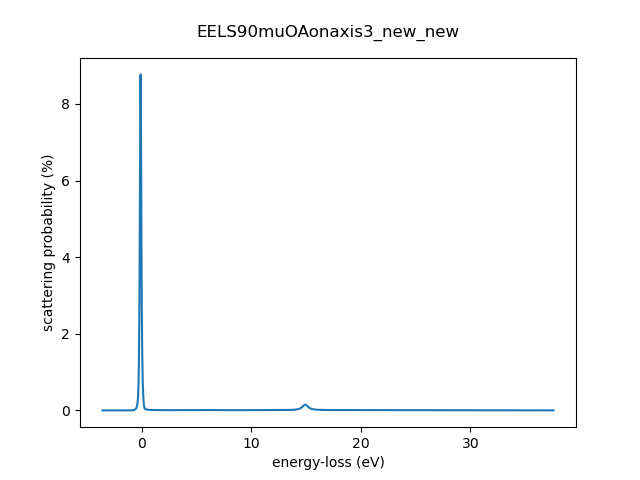

In [13]:
# ---- Input ------
load_example = True
file_name = 'AL-DFoffset0.00.dm3'
# -----------------
if load_example:
    if 'google.colab' in sys.modules:
      if not os.path.exists('./'+file_name):
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/AL-DFoffset0.00.dm3
    else:
        datasets = file_tools.open_file('../example_data/'+file_name)
        eels_dataset = datasets['Channel_000']
      
else:
    datasets = fileWidget.datasets
    eels_dataset = fileWidget.selected_dataset
    
sum_spectrum = eels_dataset.sum()

eels_dataset = eels_dataset/sum_spectrum*100.
eels_dataset.units = '%'
eels_dataset.quantity = 'scattering probability'

view = eels_dataset.plot()

In [19]:
#################################################################
## fit Zero Loss peak with ZLfunct =
##  = convolution of Gauss with a product of two Lorentzians
##################################################################        
width = 30

spectrum = eels_dataset
energy_scale = eels_dataset.energy_loss
startx = np.argmax(spectrum)
endx = startx+width
startx = startx-width
print (startx, endx, endx-startx)


x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

print(f"Energy range for fit of zero-loss: {energy_scale[startx]:.2f} to {energy_scale[endx]:.2f}")

#guess = [0.02, 8000000, 0.1, 0.2, 1000,0.2,0.5, 1000,-0.5,-1.3, 1.01,1.0]
guess = [ 0.2, 1000,0.2,0.2, 1000,0.2 ]

p0 = np.array(guess)

def ZL(p, y, x):
    center1, amplitude1, width1, center2, amplitude2, width2 = p
    err = (y - eels_tools.zl_func(x, center1, amplitude1, width1, center2, amplitude2, width2))#/np.sqrt(y)
    return err

pZL, lsq = leastsq(ZL, p0, args=(y, x), maxfev=2000)
print('Fit of a Product of two Lorentzians')
print('Positions: ',pZL[2],pZL[5], 'Distance: ',pZL[2]-pZL[5])
print('Width: ', pZL[0],pZL[3])
print('Areas: ', pZL[1],pZL[4])
center1, amplitude1, width1, center2, amplitude2, width2 = pZL
err = (y - eels_tools.zl_func(x, center1, amplitude1, width1, center2, amplitude2, width2))/np.sqrt(np.abs(y))
print (f'Goodness of Fit: {sum(err**2)/len(y)/spectrum.sum()*1e2:.5}%')

zLoss = eels_tools.zl_func(energy_scale, center1, amplitude1, width1, center2, amplitude2, width2)

dask.array<sub, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> dask.array<add, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> dask.array<sub, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>
Energy range for fit of zero-loss: -0.73 to 0.48
Fit of a Product of two Lorentzians
Positions:  0.294990332980515 0.19179393924324303 Distance:  0.10319639373727199
Width:  -0.10189725959439722 -0.152033222480134
Areas:  0.23239780503521143 41.26648198359209
Goodness of Fit: 0.0027237%


### Fix energy scale and resolution function
While a Gaussian does not describe the shape of the zero-loss peak well, we will use it to determine the zero-loss peak position.


The energy resolution is best measured from the zero-loss without sample (through vacuum), because the quasi elastic scattering will result in a small but noticeable broadening of the zero-loss.


The maximum of the fitted Gaussian is then the origin of the energy scale.
### Fitting the Zero-Loss with a Product of Two Lorentzians
To better describe the full shape we use the product of two Lorentzians.

Compare the residuals of the Gaussian and Lorentzian fit. 

You will zoom in closely to see the difference between experimental and model zero-loss peak here.

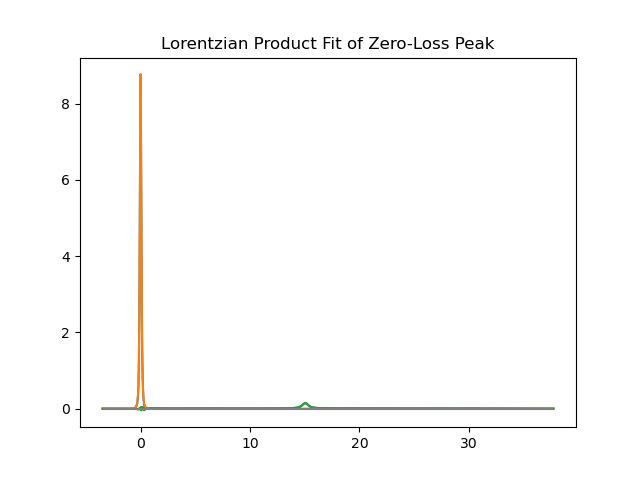

In [25]:
fig = plt.figure()
plt.plot(energy_scale,spectrum/spectrum.sum()*1e2 , label = 'spectrum')

plt.plot(energy_scale,   zLoss/spectrum.sum()*1e2, label ='resolution function')
plt.plot(energy_scale,  (spectrum-zLoss)/spectrum.sum()*1e2 , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,5)
plt.hlines(0, energy_scale[0], energy_scale[-1],color = 'gray')
Izl = zLoss.sum()

Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)





### Relative Thickness Determination

The probabaility of an low-loss function in a solid angle is then:
$$\frac{\partial^2 P}{(\partial E \partial \Omega) }= t*  \frac{e}{\pi^2 a_0 m_0 v^2} {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
Please see **Kroeger Formalism** for inclusion of retardation effects, and surface plasmons.

The integration over the (effective) collection angle gives:
$$\frac{\partial P}{\partial E} = \int_0^{\theta_c}\frac{\partial^2 P}{(\partial E \partial \Omega) }(E,\theta)\sin \theta\ d \theta$$

So we need to get the loss-function, calculate $\frac{\partial^2 P}{(\partial E \partial \Omega) }$ and then integrate over the angles, then we fit this to the spectrum with the sole variable of the thickness $t$.

The specimen thickness $t$, it is actually the total scattering
and mass thickness that is measured by EELS. If the physical density of a
material were reduced by a factor $f$, the scattering per atom would remain the same
(according to an atomic model) and the mean free path should increase by a factor $f$.

The big problem hoewver, is that one has to know the **dielectric function**. 
In the case of the Drude theory, that means we need to know the electron density.

Any approximation, therefore, needs to approximate this dielectric function, which cannot be generally applicable.


The relative thickness $ t_{rel} = t/\lambda$, in contrast, is relatively easy to determine. All the above problems are hidden in value of the inelastic mean free path (IMFP) $\lambda$, which is the inverse of the cross section above.

**When you use a tabulated value for the IMFP, be aware that this value depends on:**
* acceleration voltage
* effective collection angle
* material density
 
>**and may not be applicable for your experimental setup.**



The measurement of the relative thickness $t_{rel}$ is relative easy:

We already did this in the  [Fit Zero-Loss](./CH4_02-Fit_Zero_Loss.ipynb) part.

The inelastic scattering can be viewed in terms of independent collisions, whose occurrences obey Poisson statistics. The probability that a transmitted electron suffers $n$ collisions is 
\begin{equation} \Large
P_n = (1/n!)m^n \exp(-m)
\end{equation}

where $m$ is the number of average collisions for electrons travel through this sample area. The number $m$ can be set to the scattering parameter $t/\lambda$. $P_n$ is represented in the EELS spectrum by the ration of the energy-integrated intensity $I_n$ of $n$-fold scattering divided by the {\bf total} integrated intensity $I_t$:
\begin{equation} \Large
P_n =    I_n/I_t (1/n!) (t/\lambda)^n \exp(-t/\lambda)
\end{equation}

For a given order $n$ of scattering, the intensity  is highest when $t/\lambda =n$
In the case of the unscattered (n=0) component (zero--loss peak), the intensity is highest at t=0 and decreases exponentially with specimen thickness. For $n=0$, equation \ref{equ:poisson} gives equation 
\begin{equation} \Large
\frac{t}{\lambda}= - \ln\left[ \frac{I_{\mbox{total}}}{I_{zl}}\right]
\end{equation}
I just replaced $I_{zl}$ with $I_0$.

Zero Loss with energy resolution of -0.15 eV at position -0.000 eV
Sum of Zero-Loss: 84 counts
Sum of Spectrum: 100 counts
thickness [IMFP]: 0.17734


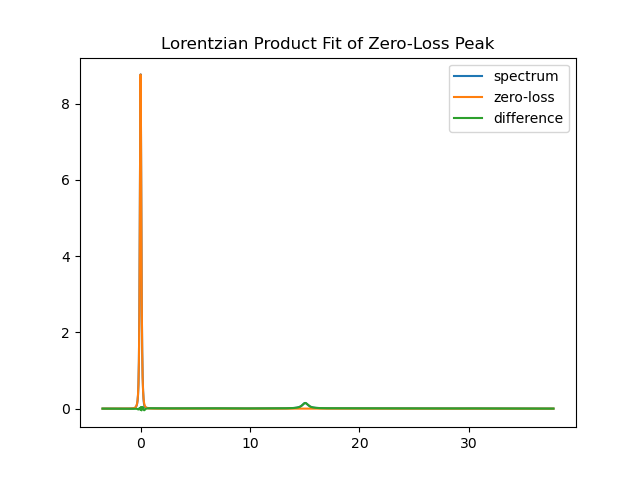

In [26]:
FWHM, energy_shift = eels_tools.get_channel_zero(np.array(eels_dataset), eels_dataset.energy_loss)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {energy_shift:.3f} eV')
eels_dataset.energy_loss -= energy_shift

zero_loss  = eels_tools.get_resolution_functions(eels_dataset)

plt.figure()
plt.plot(eels_dataset.energy_loss, eels_dataset, label='spectrum')
plt.plot(eels_dataset.energy_loss, zero_loss, label = 'zero-loss')
plt.plot(eels_dataset.energy_loss, np.array(eels_dataset)-zero_loss , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')



## Dielectric Theory

### Comparison to Optical Spectroscopy

The interaction of a transmitted electron with a solid is here described in terms of
a dielectric response function $\varepsilon(q, \omega))$. 

The same response function $\varepsilon(q, \omega))$ describes
the interaction of any electro-magnetic wave (such as photons)  with a solid, so this formalism allows energy-loss data to be compared with the results of optical measurements.

The difference is that there is no momentum transfer in an optical transition and, therefore, the relevant dielectric function is $\varepsilon(q=0, \omega))$.


The optical dielectric function (permittivity) is a transverse property of the medium, in the sense that the electric field of an electromagnetic wave displaces electrons in a direction perpendicular to the direction of propagation, the electron density remaining
unchanged. 

The relation between the ac conductivity $\sigma$ (for dc conductivity the in metals $\varepsilon$ can go to $\inf$ and is therefore not well described) and $\varepsilon$ is :
$$ \varepsilon = 1 + \frac{4\pi \ i \sigma}{\omega} $$

The relation between the complex refractive index $n+i\kappa$ and dielectric function is:
$$ n^2-\kappa^2 ={\bf Re}(\varepsilon), \ \ 2n\kappa = {\bf Im}(\varepsilon) $$

Optical absorption spectrum is obtained through
ABS= ${\bf Im}( \varepsilon(q→0,\omega) )$

>
>So, the dielectric function describes the electrical and optical response of a material almost completely. 
>


### Dispersion 
From the Fourier representation of the Maxwell equations in the source free case, we get:
$$\frac{\epsilon_i \mu_i}{c^2} = k^2$$

which we transform into:

$$k = \frac{\omega}{c} \sqrt{\varepsilon_1 \mu}$$

which gives for non-magnetic materials:

$$k = \frac{\omega}{c} \sqrt{\varepsilon_1 }$$

for $\varepsilon_1 > 0$ the wavenumber $k$ is a real function of real $\omega$.

while for $\varepsilon_1 < 0$ the wavenumber $k$ is purely imaginary.


for light  in vacuum the permittivity $\varepsilon_1$ is a constant with value 1 and we get the equation for light line:

$$k = \frac{\omega}{c}$$

### Cross Section

$$ \frac{d^2\sigma}{dE d\Omega} = \frac{1}{\pi a_0 m_0 v^2 n_a} 
        {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
The partial cross section  $\frac{d^2\sigma}{dE d\Omega}$ gives us the probability that an incident electron will be scattered into angle $q$ with energy-loss $E$.

There are three compenents, first a term that depends on the  ``atom density`` $n_a$ (atoms per volume).

And the third term is the (Lorentzian) ``angle dependence`` with the characteristic angle $$\theta_E = E_E/(\gamma m_0v^2)$$

The second term is the ``loss-function``.

The loss function of a dielectric function $\varepsilon = \varepsilon_1+ i*\varepsilon_2$ is
$$ {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right] = \frac{\varepsilon_1(q,E)}{\varepsilon_1^2(q,E) + \varepsilon_2^2(q,E)}$$
At large energy loss and $q\approx 0$, $\varepsilon_2$ is small
and $\varepsilon_1$ close to 1, the loss function becomes proportional to
$\varepsilon_2$ and (apart from a factor of E$^{−3}$) the energy-loss spectrum is proportional to the X-ray absorption spectrum.

## Volume Plasmon Peak

Most of the inelastically scattered electron arise from interaction with outer shell electrons. These interactions, therefore, have a high intensity and are easy to obtain. The quantification of this region ($<$ 100eV)  in an EELS spectrum is rather hard.

The valence electrons in a solid can be considered as coupled oscillators which interact with each others and with the transmitted electrons. In a first approximation the valence electrons behave like a free electron gas (Fermi sea, jellium). The behavior of the electron gas is described in terms of the dielectric function $\varepsilon$.


The energy-loss function $F_{el}$ on the other hand is determined by the dielectric function $\varepsilon$ through:

$$
F_{el} = \Im \left[\frac{-1}{\varepsilon(\omega)} \right]
$$

The maximum of the energy-loss function is the plasmon--peak, which is given by:
$$
E_{max} = \left[(E_p)^2 - (\Delta E_p/2)^2\right]^{1/2}
$$

### Dielectric Theory

We investigate the plasmon excitation in the so called jellium model. This model is enough to explain the essence of this excitation, but is not as complicated as the real solid state.


The displacement of a {\it quasifree} electron (with an effective mass $m$ and not the rest mass $m_0$) due to an electric field $\vec{E}$ must fulfill the equation :
\begin{equation} \Large
m\vec{x}'' + m\Gamma \vec{x}'  =  -e\vec{E}
\end{equation}

The usage of an effective mass approximates the interaction between the valence electrons and the ion--cores. For the same reason, we introduce $\Gamma$ a damping constant. Instead of $\Gamma$, we could also use its reciprocal value $\tau = 1/\Gamma$ as in the Drude theory. This is similar to the electronic theory of conduction.


For an oscillatory field $\vec{E}= \vec{E} \exp(-i\omega t)$ above equation \ref{equ:motion} has the following solution:
\begin{equation} \Large
\vec{x} = (e\vec{E}/m)(\omega ^2+i\Gamma \omega)^{-1}
\end{equation}


The displacement gives raise to a polarization $\vec{P}  = -en\vec{x} =\varepsilon_0\chi\vec{E}$, with $\chi$ electric susceptibility and $n$ the the number of electron per unit volume. The dielectric function $\varepsilon(\omega)=1+\chi$ can be expressed as:
\begin{equation} \Large
\varepsilon(\omega)=\varepsilon_1+i\varepsilon_2 = 1-\frac{\omega_p^2}{\omega^2+\Gamma^2}+\frac{i\Gamma\omega^2_p}{\omega(\gamma^2+\Gamma^2)}
\end{equation}
Where $\omega$ is the frequency (in rad/s) of forced oscillation and $\omega_p$ is the Eigen or resonance frequency of the free electron gas, which is given by:
\begin{equation} \Large
\omega_p =\left[ \frac{ne^2}{\varepsilon_0 m} \right]^{1/2}
\end{equation}


A sudden impulse such as a transmitted electron will contain all angular frequencies (Fourier components). It will also excite the resonance frequency of the jellium. Such an oscillation with frequency $\omega_p$ can be viewed as a ``pseudoparticle`` with (plasmon) energy $E_p =\hbar \omega_p.$ We call this ``pseudoparticle``  a **plasmon**.

### Energy-Loss Function
The energy-loss function (elf) is given as shown in the beginning by:
\begin{equation} \Large
E_{el}= \left[\frac{1}{\varepsilon(\omega)}\right] = \frac{\varepsilon_2}{\varepsilon_1^2+\varepsilon_2^2}=\frac{\omega\Gamma\omega_p^2}{(\omega^2-\omega_p^2)^2 +(\omega\Gamma)^2}
\end{equation}
The energy-loss is represented by $E=\hbar \omega$ and we can rewrite equation 
\ref{equ:eels_function2} as:
\begin{equation}
 \left[\frac{1}{\varepsilon(E)}\right]  =\frac{(E\hbar/\tau)E_p^2}{(E^2-E^2)^2 +(E\hbar/\tau)^2} %
  =\frac{(E \quad \Delta E_p)E_p^2}{(E^2-E^2)^2 +(E \quad \Delta E_p)^2} 
\end{equation}


The relaxation time $\tau = 1/\Gamma$ is directly connected to the FWHM of the energy-loss function which is given by $\Delta E_p =\hbar\Gamma = \hbar/\tau$. The effect of the effective mass on the energy-loss function is rather small.\\ 
The maximum of the energy-loss function is given in equation \ref{equ:plasmon-maximum}.


The relaxation time $\tau$ represents the time for plasmon oscillations to decay in energy by  a factor $\exp(-1)=0.37$. The number of oscillations which occur within this time is $\omega_p\tau/(2\pi)=E_p/(2\pi/\Delta E_p)$. Using experimental values for $E_p$ and $\Delta E_p$ result in 5 to 0.4 oscillations. The plasmon oscillations are, therefore, heavily  damped, which depends on the band structure of the material. 

### Plasmon Energies

The calculated plasmon energies of the Jellium model with equation \ref{equ:plasmon_frequency} are already quite good as can be seen in table \ref{tbl:plasmon_frequencies}.
Only the number of valence electrons per unit area $n$ and the dielectric constant $\varepsilon_0$ are necessary for these calculations.



| Material |  $E_p$ (experimental) | $E_P$ (theoretical)|
|----------|-----------------------|--------------------|
|Li | 7.1 eV | 8.0 eV|
|Diamond | 34 eV | 31 eV|
|Si | 16.5 eV | 16.6 eV| 
|Ge | 16.0 eV | 15.6 eV|
|InSb | 12.9 eV | 12.7 eV|
|GaAs | 15.8 eV | 15.7 eV|
|NaCl | 15.5 eV | 15.7 eV|

A more sophisticated way of comparing the valence loss spectra to theory is to calculate the dielectric function. {\it Ab initio} density functional theory can be used to do these calculations. To obtain the dielectric function the valence band has to be convoluted with the conduction band. A comparison between experiment and theory is shown in the figure below. 

<img title="Plasmon--Loss peak of Li" width="50%" alt="Plasmon--Loss peak of Li" src="images/Li-plasmon.jpg">

*Plasmon--Loss peak of Li (black circles), Gibbson et al Phys.~Rev.~B {\bf 13}:2451 (1979) and calculated energy-loss function by S.~Ramachandran et al. (unpublished)}*

The plasmon--loss enables us to determine the plasmon energy, a materials parameter.
The width plasmon peak is also a characteristic of the material and is needed to determine the plasmon energy.

<img title="Plasmon-loss" width="50%" alt="Plasmon-loss" src="images/Plasmon-loss.jpg">

*Plasmon--Loss peak of SrTiO$_3$ with highlighted FWHM*

The spectrum here is quite complicated due to the surface plasmon--peak which shows up to the left of the volume plasmon--peak. We measure the energy of the maximum of the plasmon--peak (here $E_{\mbox{max}} = 31$ eV) and the width of the plasmon--peak (here $\Delta E_P = 5.3$ eV). While it is easy to determine the plasmon--peak energy , the plasmon--peak width can only be determined approximately, because we don't know how to subtract the background.

Using equation above, we find that the plasmon energy is 30.5 eV for SrTiO$_3$.



This spectrum shows the high dynamic range of an EELS spectrum. The valence loss part of the spectrum is noisy, but the zero-loss peak is not saturated. The surface plasmon peak is strong, which indicates a rather thin area. May be a little too thin. Without loss of information we can get spectra from thicker areas.


Not only the plasmon energy (or the plasmon maximum) can be used for an identification of materials,
but also the shape, especially the width of the plasmon peak.

As seen above, it is rather difficult to determine the FWHM of a plasmon peak. However, it is much easier after subtraction of the zero-loss peak, as can be seen in figure below.

<img title="Ni plasmon-loss" width="50%" alt="Ni plasmon-loss" src="images/plasmon2.jpg">

*Plasmon--Loss peak of  Ni (black) after subtraction of the zero-loss peak and with highlighted FWHM. The original spectrum and the zero-loss peak are displayed in the background.*

A comparison of the plasmon peak width of Ni (above) and Si (figure  below)
 makes it apparent  how different the shape of plasmon peaks can be. The Si plasmon peak is sharp (FWHM: 7.3 eV) and has a well defined maximum, while the Ni plasmon peak is very broad (FWHM: 40 eV).

<img title="Si plasmon-loss" width="50%" alt="Si plasmon-loss" src="images/plasmon3.jpg">
*Plasmon--Loss peak of  Si (black) after subtraction of the zero-loss peak and with highlighted FWHM. The original spectrum and the zero-loss peak are displayed in the background.*

The Si plasmon peak is obtained from a rather thin area, which also makes it easier to determine the width, because the right hand tail is not broadened by the thicker sample (please see section above about single scattering deconvolution). 

## Drude Function

The dielectric function in the Drude theory is given by two input parameters the position of the plasmon energy $E_p$
and the width of the plasmon $\Gamma$

$$ ε(ω) = ε1 + iε2 = 1 + χ = 1 − \frac{\omega_p^2}{\omega^2+\Gamma^2} + \frac{i\Gamma \omega_p^2}{\omega(\omega^2+\Gamma^2)}$$
Here $\omega$ is the angular frequency (rad/s) of forced oscillation and $\omega_p$ is the natural or resonance frequency for plasma oscillation, given by
$$ ω_p = \sqrt{\frac{ne^2}{(ε_0m_0)}} $$
A transmitted electron represents a sudden impulse of applied electric field, containing
all angular frequencies (Fourier components). Setting up a plasma oscillation of the loosely bound outer-shell electrons in a solid is equivalent to creating a pseudoparticle of energy $E_p = \hbar \omega_p$, known as a plasmon (David Pines, Elementary Excitations in Solids, 1963).

Text(0.5, 0, 'energy loss (eV)')

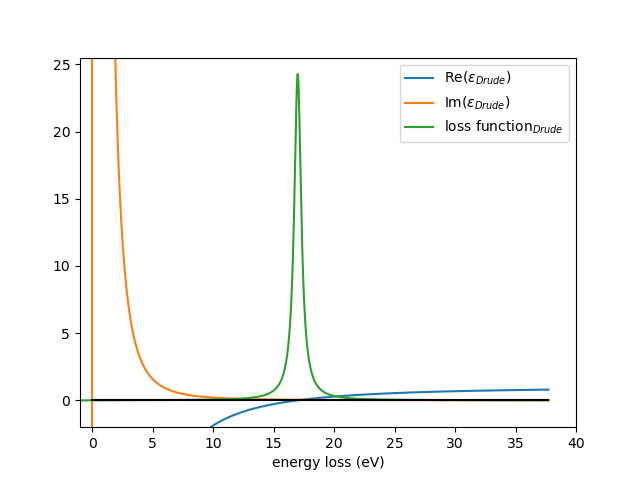

In [28]:
# ----------- Input -------------
E_p = plasmon_energy = 17. # in eV
E_w = plasmon_gamma = .7 # in eV
# -------------------------------
energy_scale = eels_dataset.energy_loss+1e-18 #= np.linspace(0,50,1024)+1e-18

def Drude(E,E_p,E_w):
    eps = 1 - E_p**2/(E**2+E_w**2) +1j* E_w* E_p**2/E/(E**2+E_w**2)
    elf = (-1/eps).imag
    return eps,elf

eps,elf = Drude(energy_scale, plasmon_energy, plasmon_gamma)

plt.figure()
plt.plot(energy_scale, eps.real, label='Re($\epsilon_{Drude}$)')
plt.plot(energy_scale, eps.imag, label='Im($\epsilon_{Drude}$)')
plt.plot(energy_scale, elf, label='loss function$_{Drude}$')
plt.plot([0,energy_scale[-1]],[0,0],c='black')

plt.legend()
plt.gca().set_ylim(-2,max(elf)*1.05);
plt.xlim(-1,40);
plt.xlabel('energy loss (eV)')

## Fitting a Drude Function to Plasmon

The position and the width are important materials parameters and we can derive them by fitting the Drude function to the volume plasmon region.

Drude Theory with Plamson Energy: 15.049794 eV and plasmon Width 0.72 eV
Max of Plasmon at 15.04 eV
Amplitude of  0.01 was deteremined by fit 


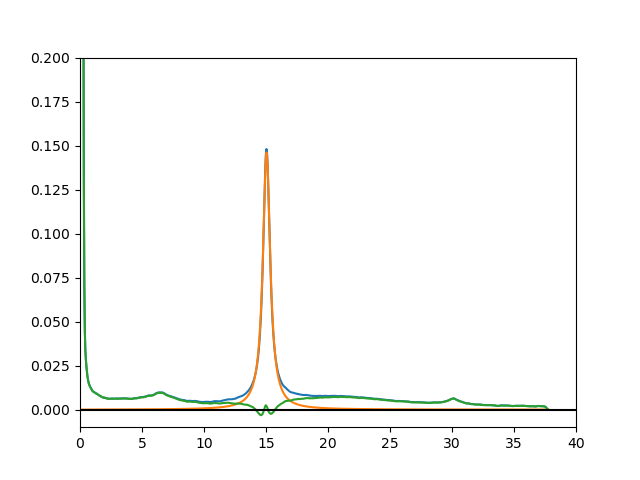

In [29]:
from scipy.optimize import leastsq

def Drude(E,Ep,Ew):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

def errfDrude(p, y, x):
    eps,elf = Drude(x,p[0],p[1])
    err = y - p[2]*elf
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([15,1,.7])
E = energy_scale
startFit =np.argmin(abs(energy_scale-13))
endFit = np.argmin(abs(energy_scale-18))
    
p2, lsq = leastsq(errfDrude, pin2, args=(ssd_low_loss[startFit:endFit], energy_scale[startFit:endFit]), maxfev=2000)

eps, elf =Drude(energy_scale,p2[0],p2[1])
drudePSD = p2[2]* elf
plt.figure()

plt.plot(energy_scale,eels_dataset)
plt.plot(energy_scale,drudePSD)
plt.plot(energy_scale,eels_dataset-drudePSD)
plt.axhline(0, color='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-0.01,0.2)
print(f"Drude Theory with Plamson Energy: {p2[0]:2f} eV and plasmon Width {p2[1]:.2f} eV") 
print(f"Max of Plasmon at {energy_scale[drudePSD.argmax(0)]:.2f} eV")
print(f"Amplitude of  {p2[2]:.2f} was deteremined by fit ")


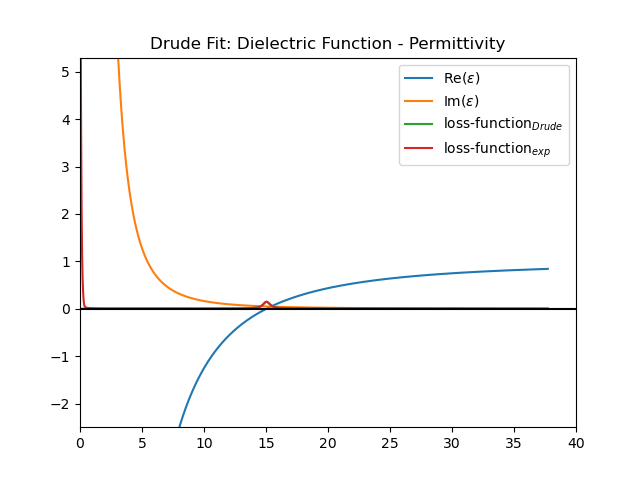

In [30]:
plt.figure()
plt.title ('Drude Fit: Dielectric Function - Permittivity')
plt.plot(energy_scale,eps.real,label = 'Re($\epsilon)$')
plt.plot(energy_scale,eps.imag,label = 'Im($\epsilon)$')
plt.plot(energy_scale,drudePSD,label = 'loss-function$_{Drude}$')
plt.plot(energy_scale,eels_dataset,label = 'loss-function$_{exp}$')
plt.axhline(0, color='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-2.5,5.3)

plt.legend();

### Plasmon Frequency and Phase Identification


Plasmon peaks occurring in EELS is directly related to valence electron density and can thereby be used as a means for materials characterization and phase identification.  Free-electron metals have very sharp plasmon peaks as compared to semiconductors and insulators with broader peaks, where the valence electrons are no longer free (covalent or ionic bonding).  While many materials properties are a function of valence electron density, knowing the plasmon energy can prove to be a useful tool in identifying micro structures.


Microstructural phases are observed by shifts in the plasmon energy. Examples of phase identification are observed easily in alloys and also precipitate structures.  A common textbook example is EELS low loss comparison of diamond and graphite.  The example given in Figure is a line scan showing the variation of plasmon energies with position.  The plasmon energies range from 21 to 23 eV, corresponding to SiC (20.8 eV) and SiN3 (22.5 eV) respectively.   Figure \ref{plasmon-ls2}  is a reconstructed map of the plasmon energies.  Blue regions correspond to SiC, while the red regions correspond to SiN3.  
    
    
Appendix C in Egerton's Electron Energy Loss Spectroscopy in the Electron Microscope lists plasmon energies of some elements and compounds [Egerton-1999].

## Surface Plasmon

Spectra from thin specimen show the excitations of the surface plasmons on each side of the specimen. For any normal specimen these surface plasmons do interact, but this is not true for extremely thick specimen ($>> 10$nm).
The surface plasmon frequency $\omega_S$ for thin specimen  is related to the bulk plasmon frequency $\omega_P$ by Ritchie [Ritchie-PR1957]:  
$$
\omega_S=\omega_P\left[  \frac{1\pm \exp(-q_st) }{1+\varepsilon} \right]^{1/2}
$$


The symmetric mode, where like charges face one another, corresponds to the higher angular frequency $q_s$. Please note, that this relationship does only apply for large $q_s$

The differential probability for surface excitation at both surfaces of a sample with thickness $t$ can be expressed (normal incident, no retardation effects) by:
$$
\frac{d^2 P_s}{d\Omega d E}=\frac{2\hbar}{\pi^2 \gamma a_0 m_0^2 \mu^3}\frac{\theta}{(\theta^2+\theta^2_E)^2} \Im\left[  \frac{(\varepsilon_a - \varepsilon_b)^2 } {\varepsilon_a^2 \varepsilon_b}\right]
$$
with 
$$
R_c = \frac{\varepsilon_a \sin^2(tE/2\hbar\mu)}{\varepsilon_b + \varepsilon_z }\tanh (q_s t/2) 
+ \frac{\varepsilon_a \cos^2(tE/2\hbar\mu)}{\varepsilon_b + \varepsilon_a} \coth (q_s t/2) 
$$
and $\varepsilon_a$ and $\varepsilon_b$ are the permitivities of the two surfaces.


A secondary effect of the surface excitation is the reduced intensity of the bulk plasmon peak. The effect is usually smaller than 1\%, but can be larger for spectra with small collection angle, because the preferred scattering of surfuce losses into small angles.
The correction for surface plasmon will be discussed in the Kramers--Kronig Analysis.



## Summary

The beauty of ``Low--Loss spectroscopy`` is its derivation of the dielectric function to high energies without prior knowledge of the composition. The signal is strong and the acquisition time is mostly restricted by the dynamic range of the spectrum.


**Think of low-loss spectroscopy as Electrodynamics**

The advantages of EELS is the derivation of these values spatially resolved.
And from a linescan across an Si/SiO$_2$ interface the dielectric function per pixel can be obtained. From that we can calculate the dielectric polarizability $\alpha_e (E)$, which may be  a measure of the dielectric strength.


We obtain more or less easily:
- relative thickness
- absolute thickness 
- inelastic mean free path
- plasmon frequency
- plasmon width
- band gap
- dielectric function
- reflectivity 
- absorption
- effective number of electrons per atoms 
 


The analysis of the optical data requires the exact knowledge of the zero-loss peak. Because of the weighting in the Fourier Analysis, the low energy part contributes heavily to the dielectric function. Therefore, energy resolution is critical for an exact determination of all the optical values from EELS. The new monochromated TEMs are now able to achieve an energy resolution of 10 meV (one is at the oak Ridge National Laboratory), which allows for a sharper zero-loss peak. Such a sharp zero-loss peak will enable us to extract this low energy data more accurately. The dielectric function and the parameters derived from it, can be more precisely determined from such EELS spectra.
